In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import SimpleITK as sitk
from ipywidgets import interact

## Affichage des images CT et segmentées
-----------

In [2]:
img  = sitk.ReadImage('./images/p1/ct.mhd')
arr_img = sitk.GetArrayFromImage(img)
img_lab = sitk.ReadImage('./images/p1/roi/body_38_2mm.mhd')
arr_img_lab = sitk.GetArrayFromImage(img_lab)


In [3]:
def myshow(coupe):
    fig, ax = plt.subplots(1,2, figsize=(10, 5))
    ax[0].imshow(arr_img[coupe], cmap=plt.cm.gray);
    ax[1].imshow(arr_img_lab[coupe]);

In [4]:
interact(myshow, coupe=(0,img_lab.GetDepth()-1));

A Jupyter Widget

## Ré-échantillonnage
----

In [5]:
resample_img_lab = sitk.Resample(img_lab, img, sitk.Transform(), sitk.sitkNearestNeighbor, 0)

(380, 249, 249)

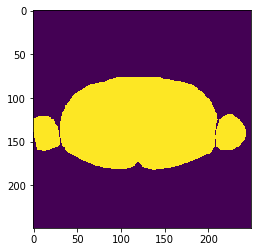

In [6]:
plt.imshow(sitk.GetArrayFromImage(resample_img_lab)[189]);
sitk.GetArrayFromImage(sitk.BinaryContour(resample_img_lab, fullyConnected=True)).shape

## Fusion des images CT et de labels
----------

In [7]:
def my_label_show(coupe, percent):
    overlay_lab_img = sitk.LabelOverlay(sitk.Cast(sitk.RescaleIntensity(img),sitk.sitkUInt8), 
                                    resample_img_lab, percent)    
    arr_overlay_lab = sitk.GetArrayFromImage(overlay_lab_img)
    plt.imshow(arr_overlay_lab[coupe]);

In [8]:
interact(my_label_show, coupe=(0, img.GetDepth()-1), percent=(0,1,0.1));

A Jupyter Widget

## Extraction des informations HU
---------

In [9]:
stats = sitk.LabelStatisticsImageFilter()
stats.Execute(img, resample_img_lab)
print(stats.GetCount(1), stats.GetMaximum(1), stats.GetMinimum(1), stats.GetMean(1), stats.GetSigma(1))

6209454 3065.0 -1806.0 -47.74961888758657 196.16625465956906


## Chargement de plusieurs fichiers de labels
-----------

In [38]:
import glob
import re
label_files = glob.glob('.\\images\\p1\\roi\\*2mm_2mm.mhd')
print("Nombre d'images : ", len(label_files))
dico_label_files = {}
chg_label = sitk.ChangeLabelImageFilter()
d_map = sitk.DoubleDoubleMap()
for i, label_file in enumerate(label_files):
    key = re.search(r'.*\\(\w+_\d+)_2mm_2mm.*', label_file).group(1)
    d_map[0] = 0
    d_map[1] = i+1
    if not re.match('.*body.*', label_file):        
        chg_label.SetChangeMap(d_map)
    image = sitk.Resample(sitk.ReadImage(label_file), img, sitk.Transform())
    image = chg_label.Execute(image)
    dico_label_files[key] = {'file': label_file, 'sitk_file': image, 'label_idx':i+1}

Nombre d'images :  17


In [40]:
#dico_label_files['spleen_862']['sitk_file'] , dico_label_files['body_38']['sitk_file']
image_sum_labels = sitk.Image(img.GetWidth(), img.GetHeight(), img.GetDepth(), sitk.sitkUInt8)
image_sum_labels.SetOrigin(img.GetOrigin())
image_sum_labels.SetSpacing(img.GetSpacing())
for label in dico_label_files.keys():
    if not re.match('.*body.*', label):
        image_sum_labels = sitk.Add(image_sum_labels,
                                          dico_label_files[label]['sitk_file'])
image_sum_labels = sitk.Add(image_sum_labels, dico_label_files['body_38']['sitk_file'])
arr_tmp = sitk.GetArrayFromImage(image_sum_labels)

def tmp_show(coupe):
    plt.imshow(arr_tmp[coupe], cmap=plt.cm.Accent_r);

interact(tmp_show, coupe=(0, img.GetDepth()-1));

sitk.WriteImage(image_sum_labels,'labelmap.mhd')

A Jupyter Widget

In [41]:
stats_all = sitk.LabelIntensityStatisticsImageFilter()
stats_all.Execute(image_sum_labels, img)
for label in dico_label_files.keys():
    if not 'body' in label:
        indice = dico_label_files[label]['label_idx']+1       
    else:
        indice = dico_label_files[label]['label_idx']
    nb_pixels = stats_all.GetNumberOfPixels(indice)
    mean = stats_all.GetMean(indice)
    maxi = stats_all.GetMaximum(indice)
    std = stats_all.GetStandardDeviation(indice)
    str_ind = '{1}\t{0}\t{2}\t{3:.3f}\t{4:.3f}\t{5}'.format(label, indice, nb_pixels, 
                                                       nb_pixels*(img.GetSpacing()[0]/10)**3, 
                                                       mean, maxi)
    print(str_ind)

1	body_38	5824282	46594.256	-49.624	3065.0
3	bone_marrow_269	18731	149.848	92.698	408.0
4	heart_268	66590	532.720	28.619	1150.0
5	left_kidney_865	830	6.640	-41.581	60.0
6	lesion01_866	6599	52.792	36.247	86.0
7	lesion02_867	1141	9.128	22.485	76.0
8	lesion03_868	1600	12.800	33.219	72.0
9	lesion04_869	10917	87.336	36.084	103.0
10	lesion05_870	2768	22.144	24.204	510.0
11	lesion06_871	502	4.016	23.797	67.0
12	lesion07_872	578	4.624	7.858	221.0
13	lesion08_873	1668	13.344	19.293	66.0
14	lesion09_874	2096	16.768	28.794	79.0
15	lesion10_875	539	4.312	39.217	72.0
16	liver_267	143370	1146.960	55.788	193.0
17	right_kidney_864	21388	171.104	21.152	126.0
18	spleen_862	16907	135.256	45.548	205.0
